In [1]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm.auto import tqdm

C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
x = [4,5,6,6,5,6,3,3,6,4,5,3,1,4,5,1,4,3]

In [3]:
c = collections.Counter()
c.update(x)

In [6]:
for i in range(1, 7):
    print(c[i])

2
0
4
4
4
4


In [7]:
stats.chisquare([2, 0, 4, 4, 4, 4])

Power_divergenceResult(statistic=4.666666666666666, pvalue=0.4578982272454014)

**Задание 1**

Проанализировать набор данных и ответить на следующие вопросы:

1) Какой % наблюдений выходит за 5 и 95 перцентиль?

2) Какому закону распределения отвечают данные? На основе чего вы так решили?

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

Описание данных:

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

In [302]:
df = pd.read_csv('task_1.csv', sep=';')['metrics']

In [303]:
l, r = np.percentile(df, [5, 95])
print("Left: ", l, "right: ", r)
print("Выходит за границы {:.4f}% выборки".format(100 * ((df < l) | (df > r)).mean()))

Left:  1.0 right:  52.0
Выходит за границы 4.9873% выборки


In [304]:
def dist_to_buckets(data):
    cnt = collections.Counter()
    cnt.update(data)
    res = []
    for i in range(max(data) + 1):
        res.append(cnt[i])
    return np.array(res)

def sqweeze_buckets(*data):
    arrays = [[] for _ in range(len(data))]
    is_start = False
    for row in zip(*data):
        if all(row):
            is_start= True
            for i, item in enumerate(row):
                arrays[i].append(item)
        elif is_start:
            break
                
    arrays = [np.array(it) for it in arrays]
    return tuple(arrays)

In [306]:
p = 0.1
b1 = dist_to_buckets(geom.rvs(p, size=100000))
b2 = dist_to_buckets(geom.rvs(p, size=100000))
len(b1), len(b2)

(117, 116)

In [307]:
b1, b2 = sqweeze_buckets(b1, b2)
len(b1), len(b2)

(82, 82)

In [308]:
dist = stats.expon
b1 = pd.Series(dist.rvs(p, size=1000), name='left').value_counts()
b2 = pd.Series(dist.rvs(p, size=1000), name='right').value_counts()
# common = pd.merge(b1,b2, left_index=True, right_index=True)
# b1 = common['left']
# b2 = common['right']
chisquare(b1, b2)

Power_divergenceResult(statistic=0.0, pvalue=1.0)

In [309]:
pd.Series(dist.rvs(p, size=1000), name='left').value_counts()

2.031690    1
1.174442    1
1.583007    1
0.479560    1
1.526679    1
           ..
0.433114    1
0.601933    1
0.471330    1
0.214188    1
1.556966    1
Name: left, Length: 1000, dtype: int64

Power_divergenceResult(statistic=inf, pvalue=0.0)

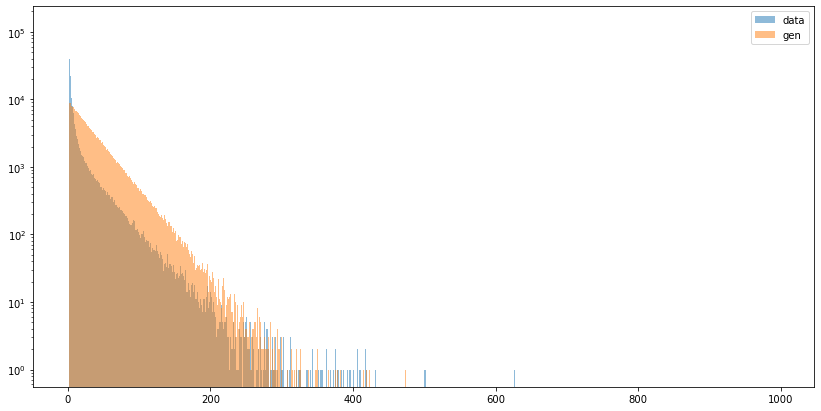

In [311]:
clean = df.copy()
l, r = np.percentile(df, [5, 99.9])
# clean = df[~((df < l) | (df > r))].copy()
# clean -= clean.min()

p = 0.3/clean.mean()
# p = (-1 + np.sqrt(4*clean.var() + 1))/(2*clean.var())

gen_data = geom.rvs(p, size=len(clean))
# d = (m - 2*v)**2 - 4*v*(v-m)
# d = d**0.5
# p = (2*v-m-d)/(2*v)
# r = m*(1-p)/p
# p, r
# gen_data = nbinom.rvs(p, r, size=len(clean))
# gen_data = poisson.rvs(p, size=len(clean))


assert len(gen_data) == len(clean)

bins = np.arange(1, max(max(clean), max(gen_data)))
plt.figure(figsize=(14, 7))
plt.yscale('log')
plt.hist(clean, bins=bins, alpha=0.5, label='data')
plt.hist(gen_data, bins=bins, alpha=0.5, label='gen')
plt.legend()

cnt_exp = collections.Counter()
cnt_exp.update(clean)
cnt_gen = collections.Counter()
cnt_gen.update(gen_data)

cols = [(cnt_exp[col],cnt_gen[col])  for col in bins if cnt_exp[col]]
exp_data = [col[0] for col in cols]
gen_data = [col[1] for col in cols]

chisquare(exp_data, f_exp=gen_data)

In [202]:
d = (m - 2*v)**2 - 4*v*(v-m)
d = d**0.5
p = (2*v-m-d)/(2*v)
r = m*(1-p)/p
p, r

(0.9349931030103155, 0.41329786761135173)

Распределение похоже на экспоненциальное или смесь геометрических

**Задание 2**

Определить, можно сравнить две представленные выборки t критерием Стьюдента? 

Если нельзя сравнивать t-критерием, то что будем использовать и почему?

Ответ аргументировать и описать 

[Ссылка на данные](https://drive.google.com/file/d/1blvC6TEBWghhVMexjOdoGEjzhZZh3wSy/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

*Вместе с ответом на задание приложить код*

In [212]:
df = pd.read_csv('task_2.csv', sep=';')[['variant', 'metrics']]

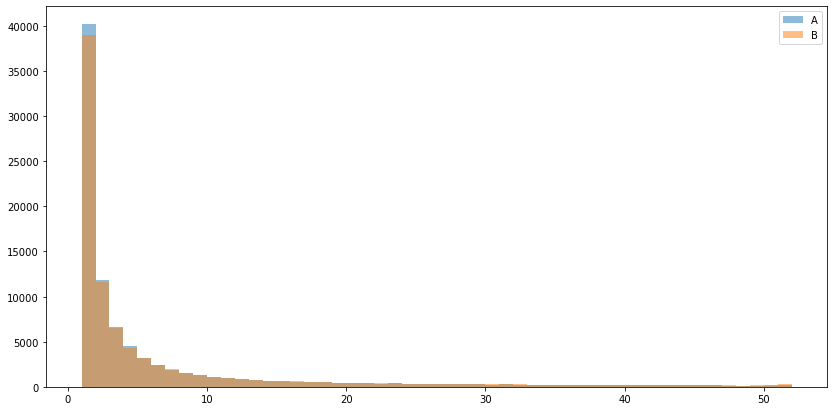

In [213]:
bins = np.arange(*np.percentile(df['metrics'], [0, 95]))

plt.figure(figsize=(14, 7))
# plt.yscale('log')
plt.hist(df[df['variant'] == 'A']['metrics'].values, bins, alpha=0.5, label='A')
plt.hist(df[df['variant'] == 'B']['metrics'].values, bins, alpha=0.5, label='B')
plt.legend();

Как можно заметить, распределение явно не нормальное, поэтому t критерий использовать нельзя.

Будем использовать бутстрап и проверять $H_0$ гипотезу о том, что выборки A и B из одного распределения.

In [214]:
def calc_stats(df, key_a='A', key_b='B'):
    _ = df.groupby('variant')['metrics'].agg(['mean', 'median']).T
    return (_[key_a] - _[key_b]).abs()

In [215]:
calc_stats(df)

mean      0.233575
median    0.000000
dtype: float64

In [216]:
def bootstrap_p_value(df, it=1000, key_a='A', key_b='B'):
    results = []
    orig = calc_stats(df, key_a, key_b)['mean']
    for i in tqdm(range(it)):
        df2 = df.copy()
        df2['metrics'] = df['metrics'].sample(frac=1, replace=True).values
        st = calc_stats(df2, key_a, key_b)
        results.append(st['mean'] >= orig)
    return np.mean(results)

In [162]:
print(f"Выборки A и B одинаковые с вероятностью {100 * bootstrap_p_value(df, 1000)}%")


Выборки A и B одинаковые с вероятностью 2.7%


Выборки одинаковые с вероятностью 2.7%, поэтому выборки отличаются с вероятностью 97.3%

**Задание 3**

Дано две выборки по А/Б тесту.

Две выборки несбалансированные - кол-во пользователей в каждой группе разные.

Метрика, которую меряем в эксперименте (и которую используем для определения группы, которая лучше себя показала) - кол-во просмотренных страниц на пользователя 

Как вы будете принимать решение, какая группа лучше А или Б, и какие статистические методы (критерии) вы будете использовать, какие преобразования к данным применять? P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

[Ссылка на данные](https://drive.google.com/file/d/1_g7Dw7-8QzTS47D6GNKMb0FzqMAWBDba/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

In [260]:
df = pd.read_csv('task_3.csv', sep=';')[['variant', 'metrics']]

In [240]:
df.groupby('variant')['metrics'].agg(['mean', 'median', 'count'])

,mean,median,count
variant,,,
A,10.099562,2,92686
D,9.942386,2,15413


Попробуем генерировать бутстреп выборки от наших выборок и посмотреть на доверительные интервалы для какой-то метрики.

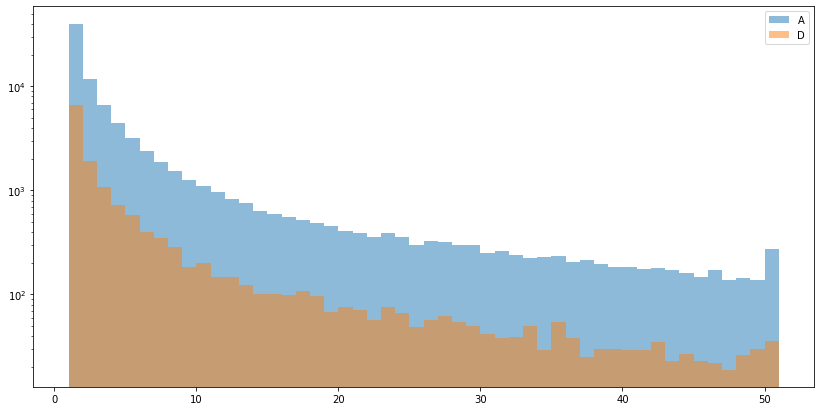

In [241]:
bins = np.arange(*np.percentile(df['metrics'], [0, 95]))

plt.figure(figsize=(14, 7))
plt.yscale('log')
plt.hist(df[df['variant'] == 'A']['metrics'].values, bins, alpha=0.5, label='A')
plt.hist(df[df['variant'] == 'D']['metrics'].values, bins, alpha=0.5, label='D')
plt.legend();

In [242]:
print(f"Выборки A и B одинаковые с вероятностью {100 * bootstrap_p_value(df, 1000, 'A', 'D')}%")


Выборки A и B одинаковые с вероятностью 44.3%


Попробуем получить интервальные оценки с помощью bootstrap

In [249]:
def bootstrap_data(df):
    return df.sample(frac=1, replace=True).values

In [250]:
def get_intervals(data, alpha):
    return np.percentile(data, [100 * alpha/2, 100 * (1-alpha/2)])

In [255]:
for let in ['A', 'D']:
    res = []
    for i in tqdm(range(1000)):
        res.append(bootstrap_data(df[df['variant'] == let]['metrics']).mean())
    print(f"Доверительные интервалы для выборки {let} = {get_intervals(np.array(res), 0.01)}")


Доверительные интервалы для выборки A = [ 9.89713123 10.29391532]



Доверительные интервалы для выборки D = [ 9.5683063  10.40632907]


In [261]:
for let in ['A', 'D']:
    res = []
    for i in tqdm(range(1000)):
        res.append(bootstrap_data(df[df['variant'] == let]['metrics']).mean())
    print(f"Доверительные интервалы для выборки {let} = {get_intervals(np.array(res), 0.5)}")


Доверительные интервалы для выборки A = [10.05559362 10.1584085 ]



Доверительные интервалы для выборки D = [ 9.81697269 10.06377733]


С более грубой оценкой получаем, что доверительный интервал для выборки A больше чем для D, поэтому выберем A

**Задание 4**

Есть данные с большой дисперсии у метрики (диспресию метрики можно посчитать для каждой группы). Для их дальнейшего анализа дисперсию необходимо сократить. Как определить, что дисперсия действительно большая? Если она большая, как вы будете ее чистить? Ответ аргументировать и описать.  P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

Описание данных: 

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

*Вместе с ответом на задание приложить код*

In [262]:
df = pd.read_csv('task_4.csv', sep=';')['metrics']

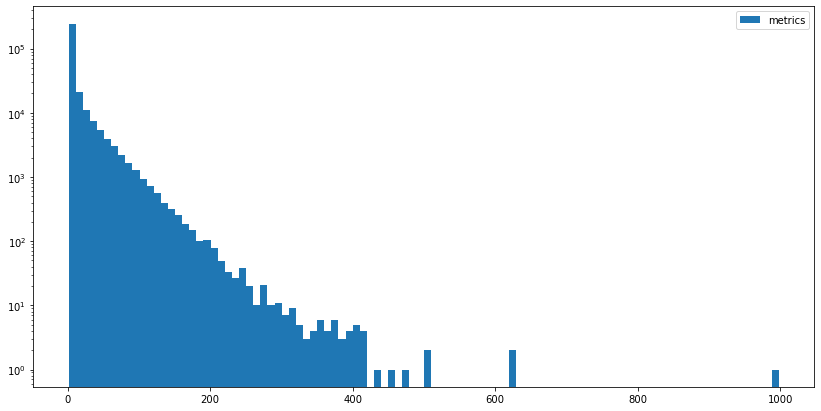

In [267]:
plt.figure(figsize=(14, 7))
plt.hist(df, bins=100, label='metrics')
plt.yscale('log')
plt.legend();

In [268]:
df.var()

511.99823268544515

У выборки большой хвост, распределение похоже на экспоненциальное.
Можно отбросить выбросы, произвести логарифмирование данных.
Оценим дисперсию с помощью bootstrap

In [263]:
def bootstrap_var(df, count, col='backet', col_stat='metrics'):
    res = []
    for i in tqdm(range(count)):
        res.append(df.sample(frac=1, replace=True).var())
    return np.array(res)

In [264]:
l, r = np.percentile(df, [1, 99])
clean = df[~((df < l) | (df > r))].copy()

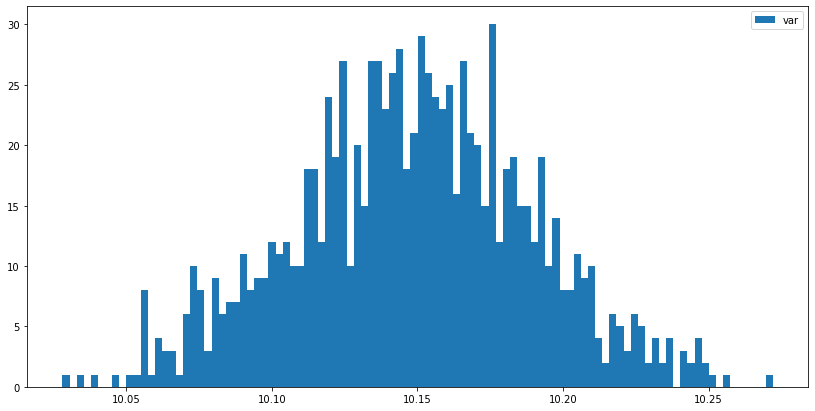

In [272]:
plt.figure(figsize=(14, 7))
plt.hist(backet_bootstrap(df, 1000), bins=100, label='var')
plt.legend();

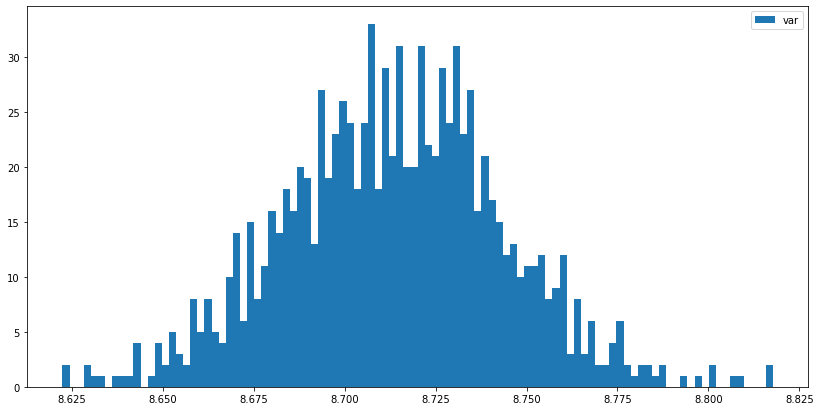

In [273]:
plt.figure(figsize=(14, 7))
plt.hist(backet_bootstrap(clean, 1000), bins=100, label='var')
plt.legend();

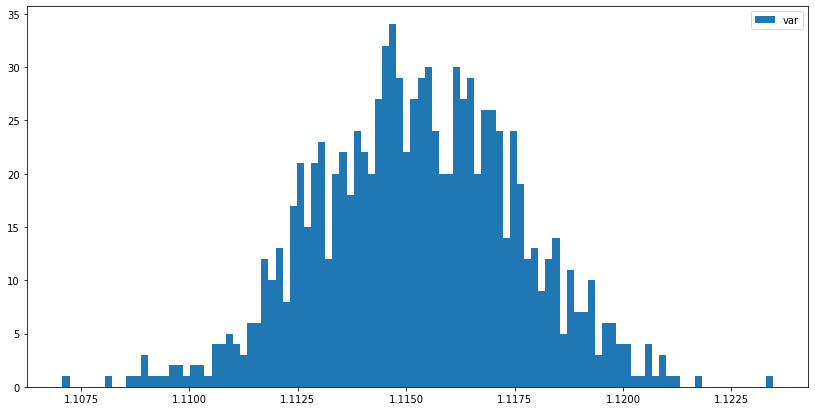

In [274]:
plt.figure(figsize=(14, 7))
plt.hist(backet_bootstrap(np.log(clean), 1000), bins=100, label='var')
plt.legend();

Как можно заметить, выборочная дисперсия сильно уменьшилась после логарифмирования данных

**Задание 5**

Есть эксперимент с поисковыми подсказками. Вы хотим узнать, как изменился CTR в каждой группе эксперимента.

**Данные**

- id - уникальный идентификатор пользователя
- action -
- view - кол-во просмотров на одну сессию
- variant - вариант a/b теста, где 0 - это версия "A", 1 -  версия "B".

**Задача**

- сформировать метрику для оценки эксперимента
- подобрать критерий под особенности данных
- сделать вывод о значимости эффекта

**Данные** 

[Ссылка на данные](https://www.dropbox.com/s/fdki267uilkfq7l/task5.csv)

In [313]:
df = pd.read_csv('task_5.csv', sep=',')[['variant', 'view', 'action']]
df['ctr'] = df['action'] / df['view']

In [314]:
df.head()

,variant,view,action,ctr
0,A,10,2,0.200000
1,A,3,1,0.333333
2,A,7,5,0.714286
3,A,9,9,1.000000
4,A,1,1,1.000000


In [315]:
df.groupby('variant')[['view', 'action', 'ctr']].agg(['sum', 'count', 'mean'])

view                 action                          ctr        \
           sum count      mean    sum count      mean          sum count   
variant                                                                    
A        20303  4646  4.369996  12369  4646  2.662290  3538.318795  4646   
B        15883  3545  4.480395   9627  3545  2.715656  2681.784149  3545   

                   
             mean  
variant            
A        0.761584  
B        0.756498

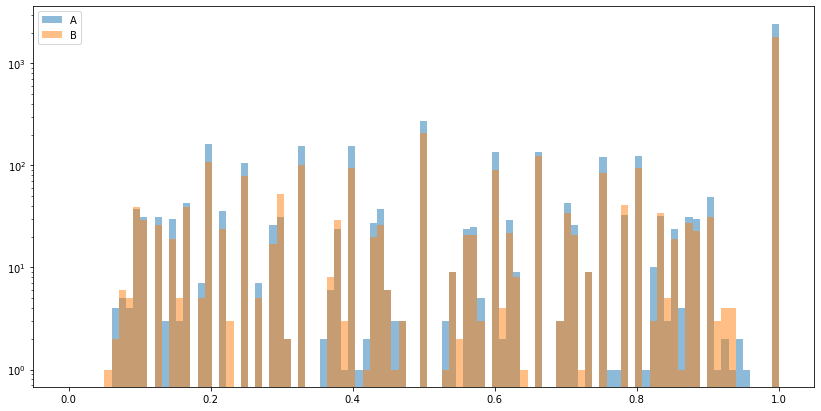

In [316]:
bins = np.linspace(0, 1, 100)

plt.figure(figsize=(14, 7))
plt.yscale('log')
plt.hist(df[df['variant'] == 'A']['ctr'].values, bins, alpha=0.5, label='A')
plt.hist(df[df['variant'] == 'B']['ctr'].values, bins, alpha=0.5, label='B')
plt.legend();

In [319]:
np.random.seed(0)
for let in ['A', 'B']:
    res = []
    for i in tqdm(range(1000)):
        res.append(bootstrap_data(df[df['variant'] == let]['ctr']).mean())
    print(f"Доверительные интервалы для выборки {let} = {get_intervals(np.array(res), 0.01)}")


Доверительные интервалы для выборки A = [0.7497863  0.77180423]



Доверительные интервалы для выборки B = [0.74442776 0.76976849]


In [320]:
la, ra = [0.7497863,  0.77180423]
lb, rb = [0.74442776, 0.76976849]

In [327]:
np.random.seed(0)
res = []
for i in tqdm(range(1000)):
    b = bootstrap_data(df[df['variant'] == 'A']['ctr']).mean()
    res.append((la <= b <= ra) & (b > rb))
print(f"p_value для выборки A = {np.array(res).mean()}")

res = []
for i in tqdm(range(1000)):
    b = bootstrap_data(df[df['variant'] == 'B']['ctr']).mean()
    res.append((lb <= b <= rb) & (b < la))
print(f"p_value для выборки B = {np.array(res).mean()}")


p_value для выборки A = 0.025



p_value для выборки B = 0.084


p value для выборки A меньше, также выборка A имеет большее ожидание значения ctr, поэтому стоит выбрать ее.